# 7 day stock predictor

Steps for Implementation:
- Fetch Stock Data
- Fetch Today’s News & Perform Sentiment Analysis
- Preprocess Data & Normalize Prices
- Train LSTM Model
- Predict Stock Prices for the Next 7 Days

### 1. Install dependancies

In [ ]:
# pip install yfinance pandas numpy tensorflow scikit-learn nltk vaderSentiment matplotlib

### 2. Import Required Libraries

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import datetime
import requests

### 3. Fetch Stock Data

In [3]:
def fetch_stock_data(ticker):
    end_date = datetime.datetime.today().date()
    start_date = end_date - datetime.timedelta(days=365)
    stock = yf.download(ticker, start=start_date, end=end_date)
    stock.reset_index(inplace=True)
    return stock[['Date', 'Close']]

In [4]:
ticker = "AAPL"  # Change to desired stock

In [5]:
stock_data = fetch_stock_data(ticker)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


### 4. Fetch Today’s News & Sentiment Analysis

In [6]:
def fetch_news_sentiment(ticker):
    news_api_key = "bfd96b792ecb43769e49c5d6b91b03eb"
    url = f"https://newsapi.org/v2/everything?q={ticker}&from={datetime.datetime.today().date()}&sortBy=publishedAt&apiKey={news_api_key}"
    
    response = requests.get(url).json()
    articles = response.get("articles", [])
    
    analyzer = SentimentIntensityAnalyzer()
    total_sentiment = 0
    count = 0
    
    for article in articles[:10]:  # Take top 10 news articles
        sentiment_score = analyzer.polarity_scores(article["title"])["compound"]
        total_sentiment += sentiment_score
        count += 1
    
    return total_sentiment / count if count > 0 else 0


In [7]:
news_sentiment = fetch_news_sentiment(ticker)

### 5. Preprocess Data for LSTM

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
stock_data['Scaled_Close'] = scaler.fit_transform(stock_data[['Close']])

def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

In [9]:
seq_length = 10
X, y = create_sequences(stock_data['Scaled_Close'].values, seq_length)
X = X.reshape(X.shape[0], X.shape[1], 1)

### 6. Train LSTM Model

In [10]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=20, batch_size=16)

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1908
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0121
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0089
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0070
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0054
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0048
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0044
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0047
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0051
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0049
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0051
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0044
Epoch 13/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0046
Epoch 14/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0049
Epoch 15/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0054
Epoc

### 7. Predict Next 7 Days

In [11]:
def predict_next_7_days(model, last_seq, sentiment):
    predictions = []
    for _ in range(7):
        pred_price = model.predict(last_seq.reshape(1, seq_length, 1))[0, 0]
        pred_price += sentiment * 0.01  # Adjust using sentiment score
        predictions.append(pred_price)
        
        last_seq = np.append(last_seq[1:], [[pred_price]], axis=0)
    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

In [12]:
last_seq = X[-1]
predicted_prices = predict_next_7_days(model, last_seq, news_sentiment)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


### 8. Plot Predictions

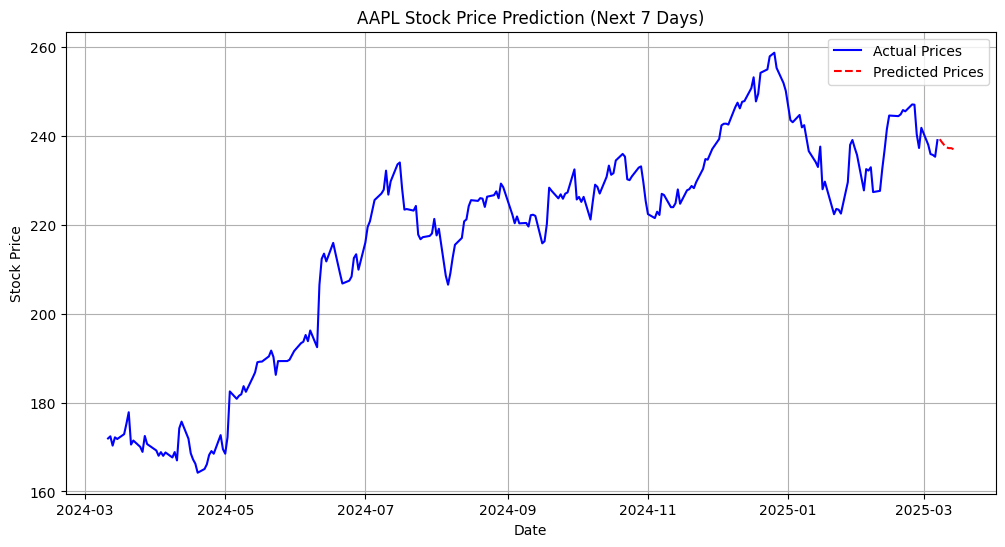

In [13]:
future_dates = [stock_data['Date'].iloc[-1] + datetime.timedelta(days=i) for i in range(1, 8)]

plt.figure(figsize=(12, 6))
plt.plot(stock_data['Date'], stock_data['Close'], label='Actual Prices', color='blue')
plt.plot(future_dates, predicted_prices, label='Predicted Prices', color='red', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title(f'{ticker} Stock Price Prediction (Next 7 Days)')
plt.legend()
plt.grid()
plt.show()

###

### Predicted vs. Actual Prices (Training Data)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


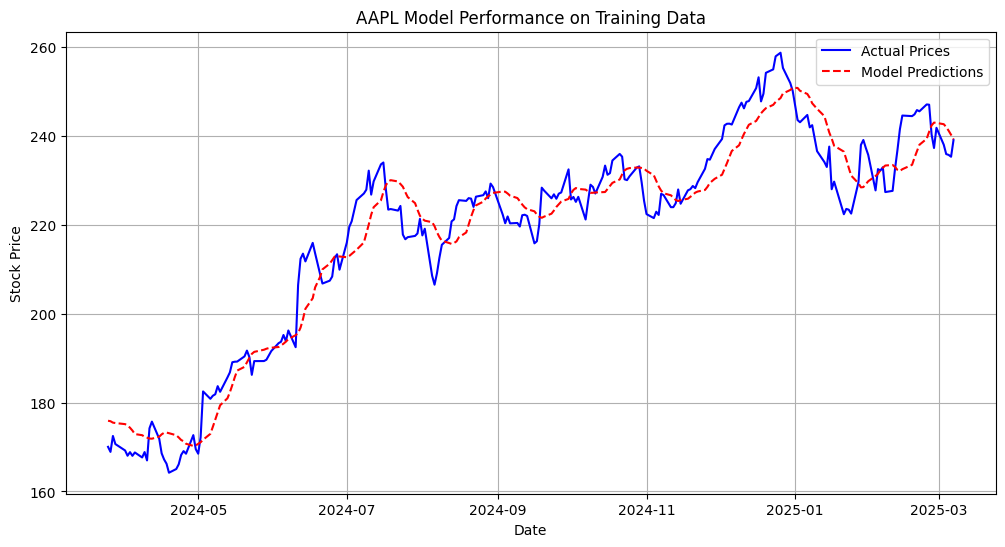

In [14]:
train_predictions = model.predict(X)
train_predictions = scaler.inverse_transform(train_predictions)

plt.figure(figsize=(12, 6))
plt.plot(stock_data['Date'][seq_length:], stock_data['Close'][seq_length:], label='Actual Prices', color='blue')
plt.plot(stock_data['Date'][seq_length:], train_predictions, label='Model Predictions', color='red', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title(f'{ticker} Model Performance on Training Data')
plt.legend()
plt.grid()
plt.show()
